In [1]:
import numpy as np
import matplotlib.pyplot as plt
import asdf
from matplotlib import rc
from scipy.optimize import curve_fit
import symlib
import sys
sys.path.append('/sdf/home/j/jaymarie/software/gravitree/python')
import gravitree
from scipy.integrate import quad
import astropy.constants as cons
import astropy.units as u
from tqdm import tqdm
from glob import glob

from plot import setFonts
setFonts()

from gala.potential import PlummerPotential

from gala.units import galactic

sim_dir = "/fs/ddn/sdf/group/kipac/g/cosmo/ki21/phil1/simulations/ZoomIns/SymphonyMilkyWay/Halo023"

from mwgcs import Simulation, GCSystem, MassProfile, NFW, Einasto, sampleDwarfGCMF

sim = Simulation(sim_dir)

Gravitree path added to sys.path.


In [21]:
sh_id = 5
gcsys = GCSystem(sim, sh_id)
gcsys.evolve(0)

14it [00:27,  1.85s/it]

Subhalo disrupted... switching potential.


91it [03:49,  2.52s/it]

done


In [22]:

gcsys.evolved_mass

array([75571.22726084, 75546.19264527, 75520.54734276, 75494.18386461,
       75466.67936368, 75434.76908419, 75377.2619292 , 75305.49484372,
       75274.42243761, 75256.55731518, 75244.68995614, 75202.85361821,
       75179.3175846 , 75170.36675837, 75164.4139008 , 75154.94573008,
       75131.04186704, 75089.44191237, 75078.38476936, 75070.84453379,
       75063.59455015, 75054.84874067, 75040.62142727, 74985.41562007,
       74955.31009239, 74941.98216157, 74932.41201843, 74922.70552574,
       74909.82600545, 74886.13647883, 74841.59351778, 74819.82602215,
       74805.14432037, 74792.65168551, 74779.62959547, 74761.84837741,
       74718.1485518 , 74680.36077983, 74665.03200846, 74652.88105522,
       74638.90552956, 74608.32925884, 74545.96086598, 74529.38684158,
       74516.38927785, 74499.29015239, 74448.47249398, 74416.07943962,
       74399.38074   , 74384.7562065 , 74365.2866346 , 74322.58991388,
       74292.35579509, 74277.41922204, 74263.78562039, 74235.11469539,
      

In [23]:
np.mean(gcsys.r)

23.534949852072675

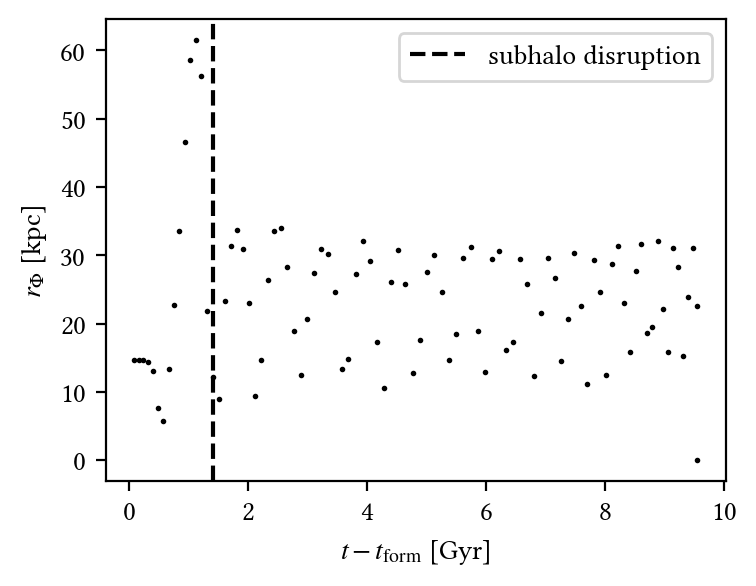

In [24]:
fig, ax = plt.subplots(dpi=200, figsize=(4,3))
_sort_idx = np.argsort(np.cumsum(gcsys.t))
ax.scatter(np.cumsum(gcsys.t)[_sort_idx], gcsys.r[_sort_idx], s=1, c='k')
ax.axvline(np.cumsum(gcsys.t)[np.where(gcsys.snaps == gcsys.disrupt_snap)[0][0]], label='subhalo disruption', ls='--', c='k')
ax.set_ylabel(r'$r_\Phi$ [kpc]')
ax.set_xlabel(r'$t-t_\mathrm{form}$ [Gyr]')
ax.legend()
plt.show()

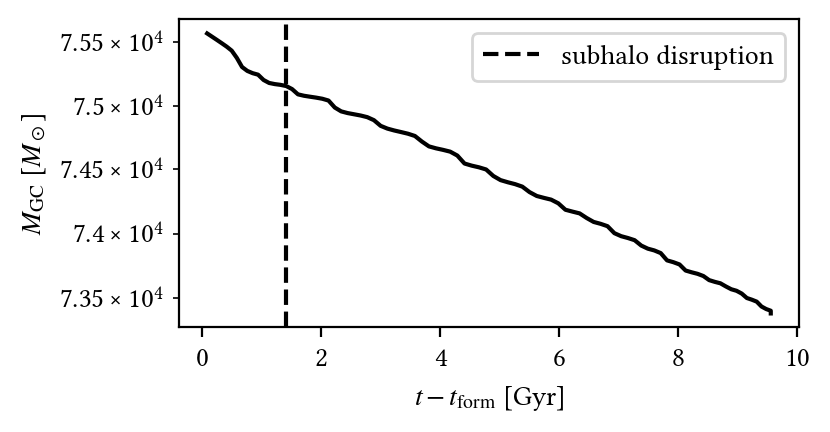

In [25]:
fig, ax = plt.subplots(dpi=200, figsize=(4,2))
_sort_idx = np.argsort(np.cumsum(gcsys.t))
ax.plot(np.cumsum(gcsys.t)[_sort_idx], gcsys.evolved_mass[_sort_idx], c='k')
ax.axvline(np.cumsum(gcsys.t)[np.where(gcsys.snaps == gcsys.disrupt_snap)[0][0]], label='subhalo disruption', ls='--', c='k')
ax.set_yscale('log')
ax.set_ylabel(r'$M_\mathrm{GC}$ [$M_\odot$]')
ax.set_xlabel(r'$t-t_\mathrm{form}$ [Gyr]')
ax.legend()
plt.show()

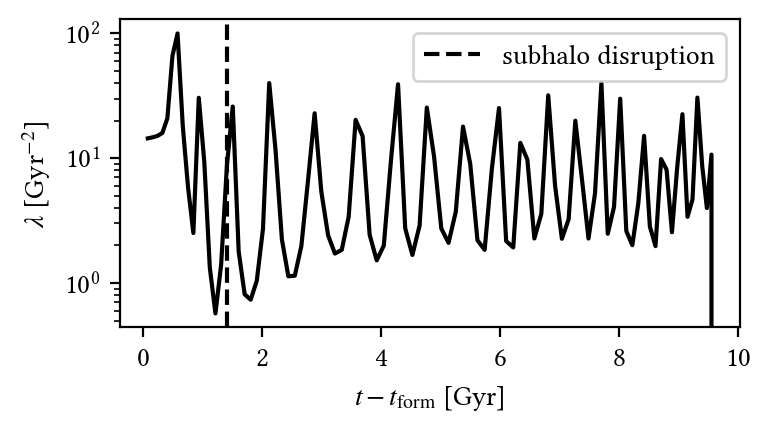

In [26]:
fig, ax = plt.subplots(dpi=200, figsize=(4,2))
_sort_idx = np.argsort(np.cumsum(gcsys.t))
ax.plot(np.cumsum(gcsys.t)[_sort_idx], gcsys.lam[_sort_idx], c='k')
ax.axvline(np.cumsum(gcsys.t)[np.where(gcsys.snaps == gcsys.disrupt_snap)[0][0]], label='subhalo disruption', ls='--', c='k')
ax.set_yscale('log')
ax.set_ylabel(r'$\lambda$ [Gyr$^{-2}$]')
ax.set_xlabel(r'$t-t_\mathrm{form}$ [Gyr]')
ax.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots(dpi=200, figsize=(4,2))

ax.scatter(gcsys.r, gcsys.lam, c='k')
ax.set_yscale('log')
ax.set_ylabel(r'$\lambda$')
ax.set_xlabel(r'$r$')

plt.show()

Subhalo has insufficient particle count, rebinning with  0  bins


ValueError: number sections must be larger than 0.

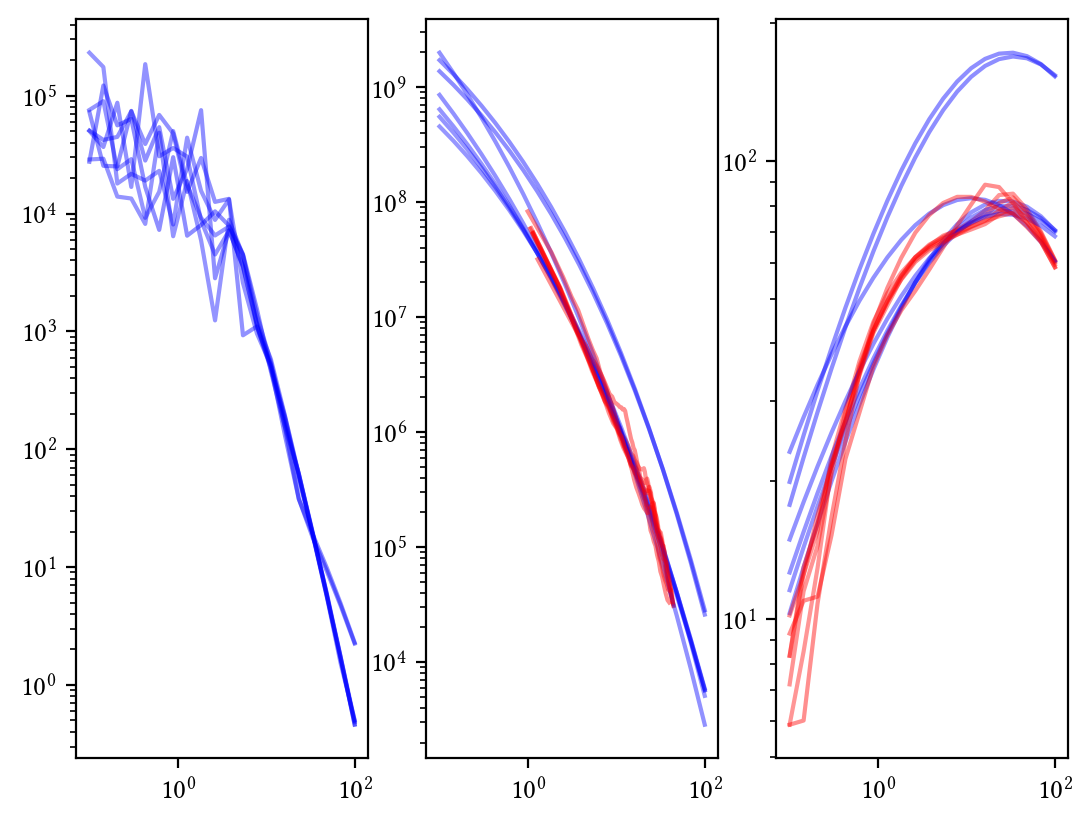

In [12]:
r = np.logspace(-1, 2, 20)

fig, ax = plt.subplots(1, 3, dpi=200)
for k in range(len(gcsys.profile_params)):
    e = Einasto(*gcsys.profile_params[k])
    lam = [e.tidalStrength([r_i, 0., 0.]) for r_i in r]
    rho = [e.density(r_i) for r_i in r]
    vcirc = [e.circularVelocity(r_i) for r_i in r]
    
    massprof = MassProfile(sim, gcsys.snaps[k], sh_id)
    _r, _rho = massprof.density()
    _vcirc = [massprof.circularVelocity(r_i) for r_i in r]
    
    ax[0].loglog(r, lam, c='blue', alpha=(gcsys.t / (np.max(gcsys.t) + .1))[k])
    
    ax[1].loglog(r, rho, c='blue', alpha=(gcsys.t / (np.max(gcsys.t) + .1))[k])
    ax[1].loglog(_r, _rho, c='red', alpha=(gcsys.t / (np.max(gcsys.t) + .1))[k])

    ax[2].loglog(r, vcirc, c='blue', alpha=(gcsys.t / (np.max(gcsys.t) + .1))[k])
    ax[2].loglog(r, _vcirc, c='red', alpha=(gcsys.t / (np.max(gcsys.t) + .1))[k])
plt.show()

In [12]:
m = MassProfile(sim, 160, 2)

In [16]:
m

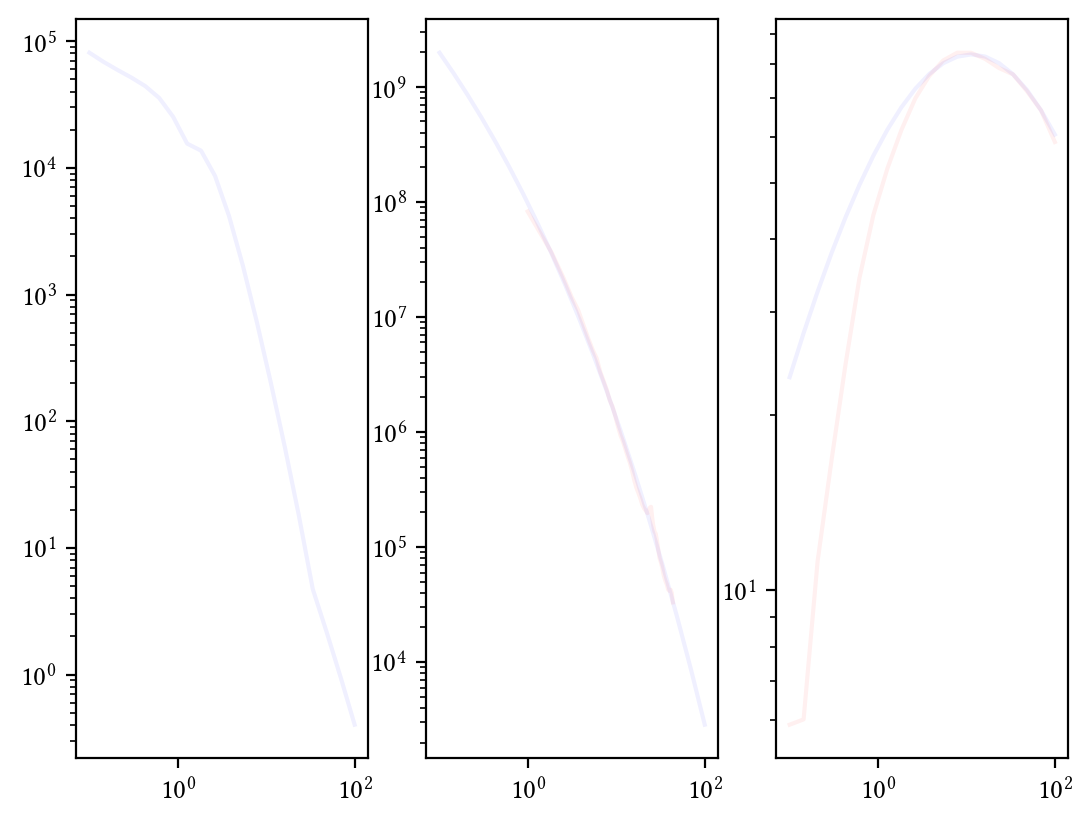

In [11]:
r = np.logspace(-1, 2, 20)

fig, ax = plt.subplots(1, 3, dpi=200)
k = -2
e = Einasto(*gcsys.profile_params[k])
lam = [e.tidalStrength([r_i, 0., 0.]) for r_i in r]
rho = [e.density(r_i) for r_i in r]
vcirc = [e.circularVelocity(r_i) for r_i in r]

massprof = MassProfile(sim, gcsys.snaps[k], sh_id)
_r, _rho = massprof.density()
_vcirc = [massprof.circularVelocity(r_i) for r_i in r]

ax[0].loglog(r, lam, c='blue', alpha=(gcsys.t / (np.max(gcsys.t) + .1))[k])

ax[1].loglog(r, rho, c='blue', alpha=(gcsys.t / (np.max(gcsys.t) + .1))[k])
ax[1].loglog(_r, _rho, c='red', alpha=(gcsys.t / (np.max(gcsys.t) + .1))[k])

ax[2].loglog(r, vcirc, c='blue', alpha=(gcsys.t / (np.max(gcsys.t) + .1))[k])
ax[2].loglog(r, _vcirc, c='red', alpha=(gcsys.t / (np.max(gcsys.t) + .1))[k])
plt.show()